# Predicción de Cancelación de Clientes (Churn) — Telco
---
**Objetivo:** Predecir si un cliente cancelará su suscripción.  
**Dataset:** [Telco Customer Churn — Kaggle](https://www.kaggle.com/datasets/blastchar/telco-customer-churn)  
**Pipeline:**
1. Análisis de Datos 
2. Preprocesamiento
3. Modelo Base — Logistic Regression
4. Modelo Avanzado — XGBoost
5. Comparación de Modelos


---
## 1. Configuración e Importaciones

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, average_precision_score
)
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

SEMILLA = 42
np.random.seed(SEMILLA)

sns.set_theme(style='darkgrid', palette='muted', font_scale=1.1)
plt.rcParams['figure.dpi'] = 120
plt.rcParams['axes.spines.top']   = False
plt.rcParams['axes.spines.right'] = False

print('Todas las librerías cargadas correctamente.')

Todas las librerías cargadas correctamente.


---
## 2. Cargar Datos

In [2]:
df = pd.read_csv('prediction/data/WA_Fn-UseC_-Telco-Customer-Churn.csv')

print(f'Dimensiones: {df.shape[0]:,} filas x {df.shape[1]} columnas')
df.head()

Dimensiones: 7,043 filas x 21 columnas


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
df.describe(include='all')

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
count,7043,7043,7043.000000,7043,7043,7043.000000,7043,7043,7043,7043,...,7043,7043,7043,7043,7043,7043,7043,7043.000000,7043,7043
unique,7043,2,NaN,2,2,NaN,2,3,3,3,...,3,3,3,3,3,2,4,NaN,6531,2
top,3186-AJIEK,Male,NaN,No,No,NaN,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,NaN,20.2,No
freq,1,3555,NaN,3641,4933,NaN,6361,3390,3096,3498,...,3095,3473,2810,2785,3875,4171,2365,NaN,11,5174
mean,NaN,NaN,0.162147,NaN,NaN,32.371149,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN,NaN
std,NaN,NaN,0.368612,NaN,NaN,24.559481,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN,NaN
50%,NaN,NaN,0.000000,NaN,NaN,29.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN,NaN
75%,NaN,NaN,0.000000,NaN,NaN,55.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN,NaN


In [5]:
# Verificación de valores faltantes
faltantes = df.isnull().sum()
faltantes = faltantes[faltantes > 0]
print('Valores faltantes:')
print(faltantes if not faltantes.empty else 'Ninguno encontrado')

Valores faltantes:
Ninguno encontrado


---
## 3. Análisis

### 3.1 Distribución del Target — Churn

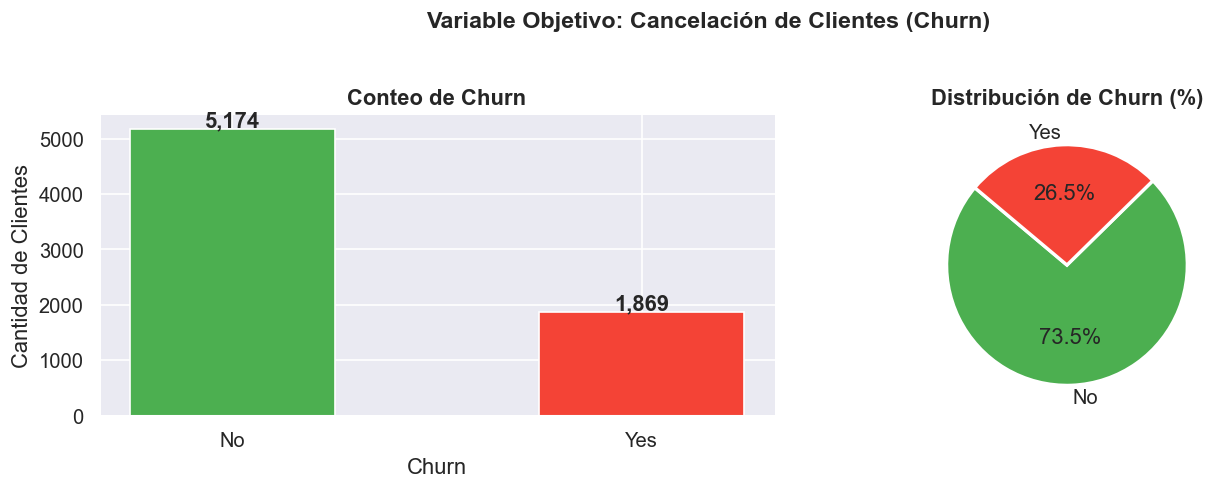

Tasa de cancelación: 26.5%  |  Tasa de retención: 73.5%


In [6]:
# Churn = Es un usuario que cancelo su subscripción
# La columna Churn es la variable Target que queremos predecir. 
# Churn Value = No -> El usuario mantiene su suscripción, Churn Value = Yes -> El Usuario canceló su suscripción
conteo_churn = df['Churn'].value_counts()
pct_churn    = df['Churn'].value_counts(normalize=True) * 100

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Gráfico de barras
barras = axes[0].bar(conteo_churn.index, conteo_churn.values,color=['#4CAF50', '#F44336'], edgecolor='white', width=0.5)
axes[0].set_title('Conteo de Churn', fontweight='bold')
axes[0].set_xlabel('Churn')
axes[0].set_ylabel('Cantidad de Clientes')
for barra, val in zip(barras, conteo_churn.values):
    axes[0].text(barra.get_x() + barra.get_width()/2, barra.get_height() + 50, f'{val:,}', ha='center', fontweight='bold')

# Gráfico de torta
axes[1].pie(conteo_churn.values, labels=conteo_churn.index, autopct='%1.1f%%', colors=['#4CAF50', '#F44336'], startangle=140, wedgeprops=dict(edgecolor='white', linewidth=2))
axes[1].set_title('Distribución de Churn (%)', fontweight='bold')

plt.suptitle('Variable Objetivo: Cancelación de Clientes (Churn)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print(f"Tasa de cancelación: {pct_churn['Yes']:.1f}%  |  Tasa de retención: {pct_churn['No']:.1f}%")

In [7]:
# El dataset esta claramente desbalanceado. Esto nos puede afectar al momento de entrenar el model debido a que el modelo podria aprender atajos 

In [8]:
# vagos como: Si siempre doy de predicción "Retención" voy a tener una tasa de acierto del 73,5%.

### 3.2 Variables Numéricas — Distribuciones

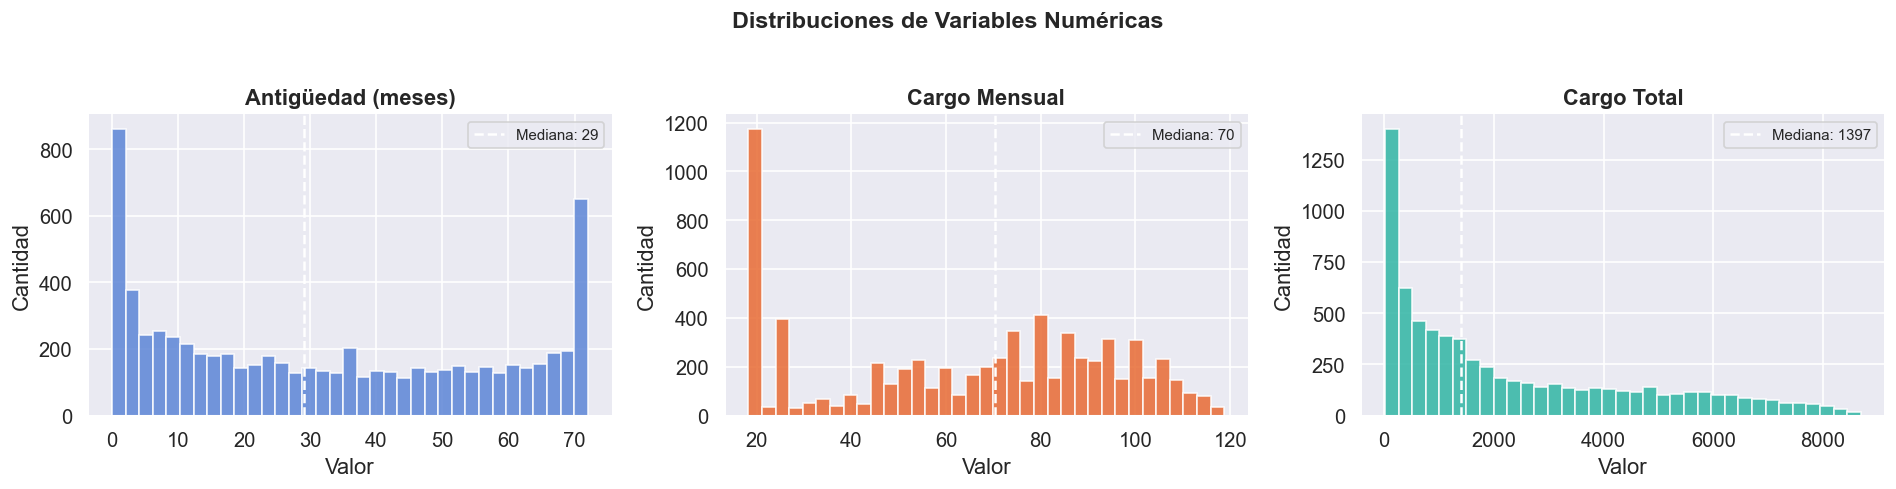

In [9]:
cols_num = ['tenure', 'MonthlyCharges', 'TotalCharges']

# TotalCharges está guardado como objeto — corregir tipo de dato
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

fig, axes = plt.subplots(1, 3, figsize=(16, 4))
colores = ['#5C85D6', '#E86A33', '#30B5A4']
etiquetas = ['Antigüedad (meses)', 'Cargo Mensual', 'Cargo Total']

for ax, col, color, etiq in zip(axes, cols_num, colores, etiquetas):
    ax.hist(df[col].dropna(), bins=35, color=color, edgecolor='white', alpha=0.85)
    ax.axvline(df[col].median(), color='white', linestyle='--', linewidth=1.5, label=f'Mediana: {df[col].median():.0f}')
    ax.set_title(etiq, fontweight='bold')
    ax.set_xlabel('Valor')
    ax.set_ylabel('Cantidad')
    ax.legend(fontsize=9)

plt.suptitle('Distribuciones de Variables Numéricas', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 3.3 Variables Categóricas — Gráficos de Conteo

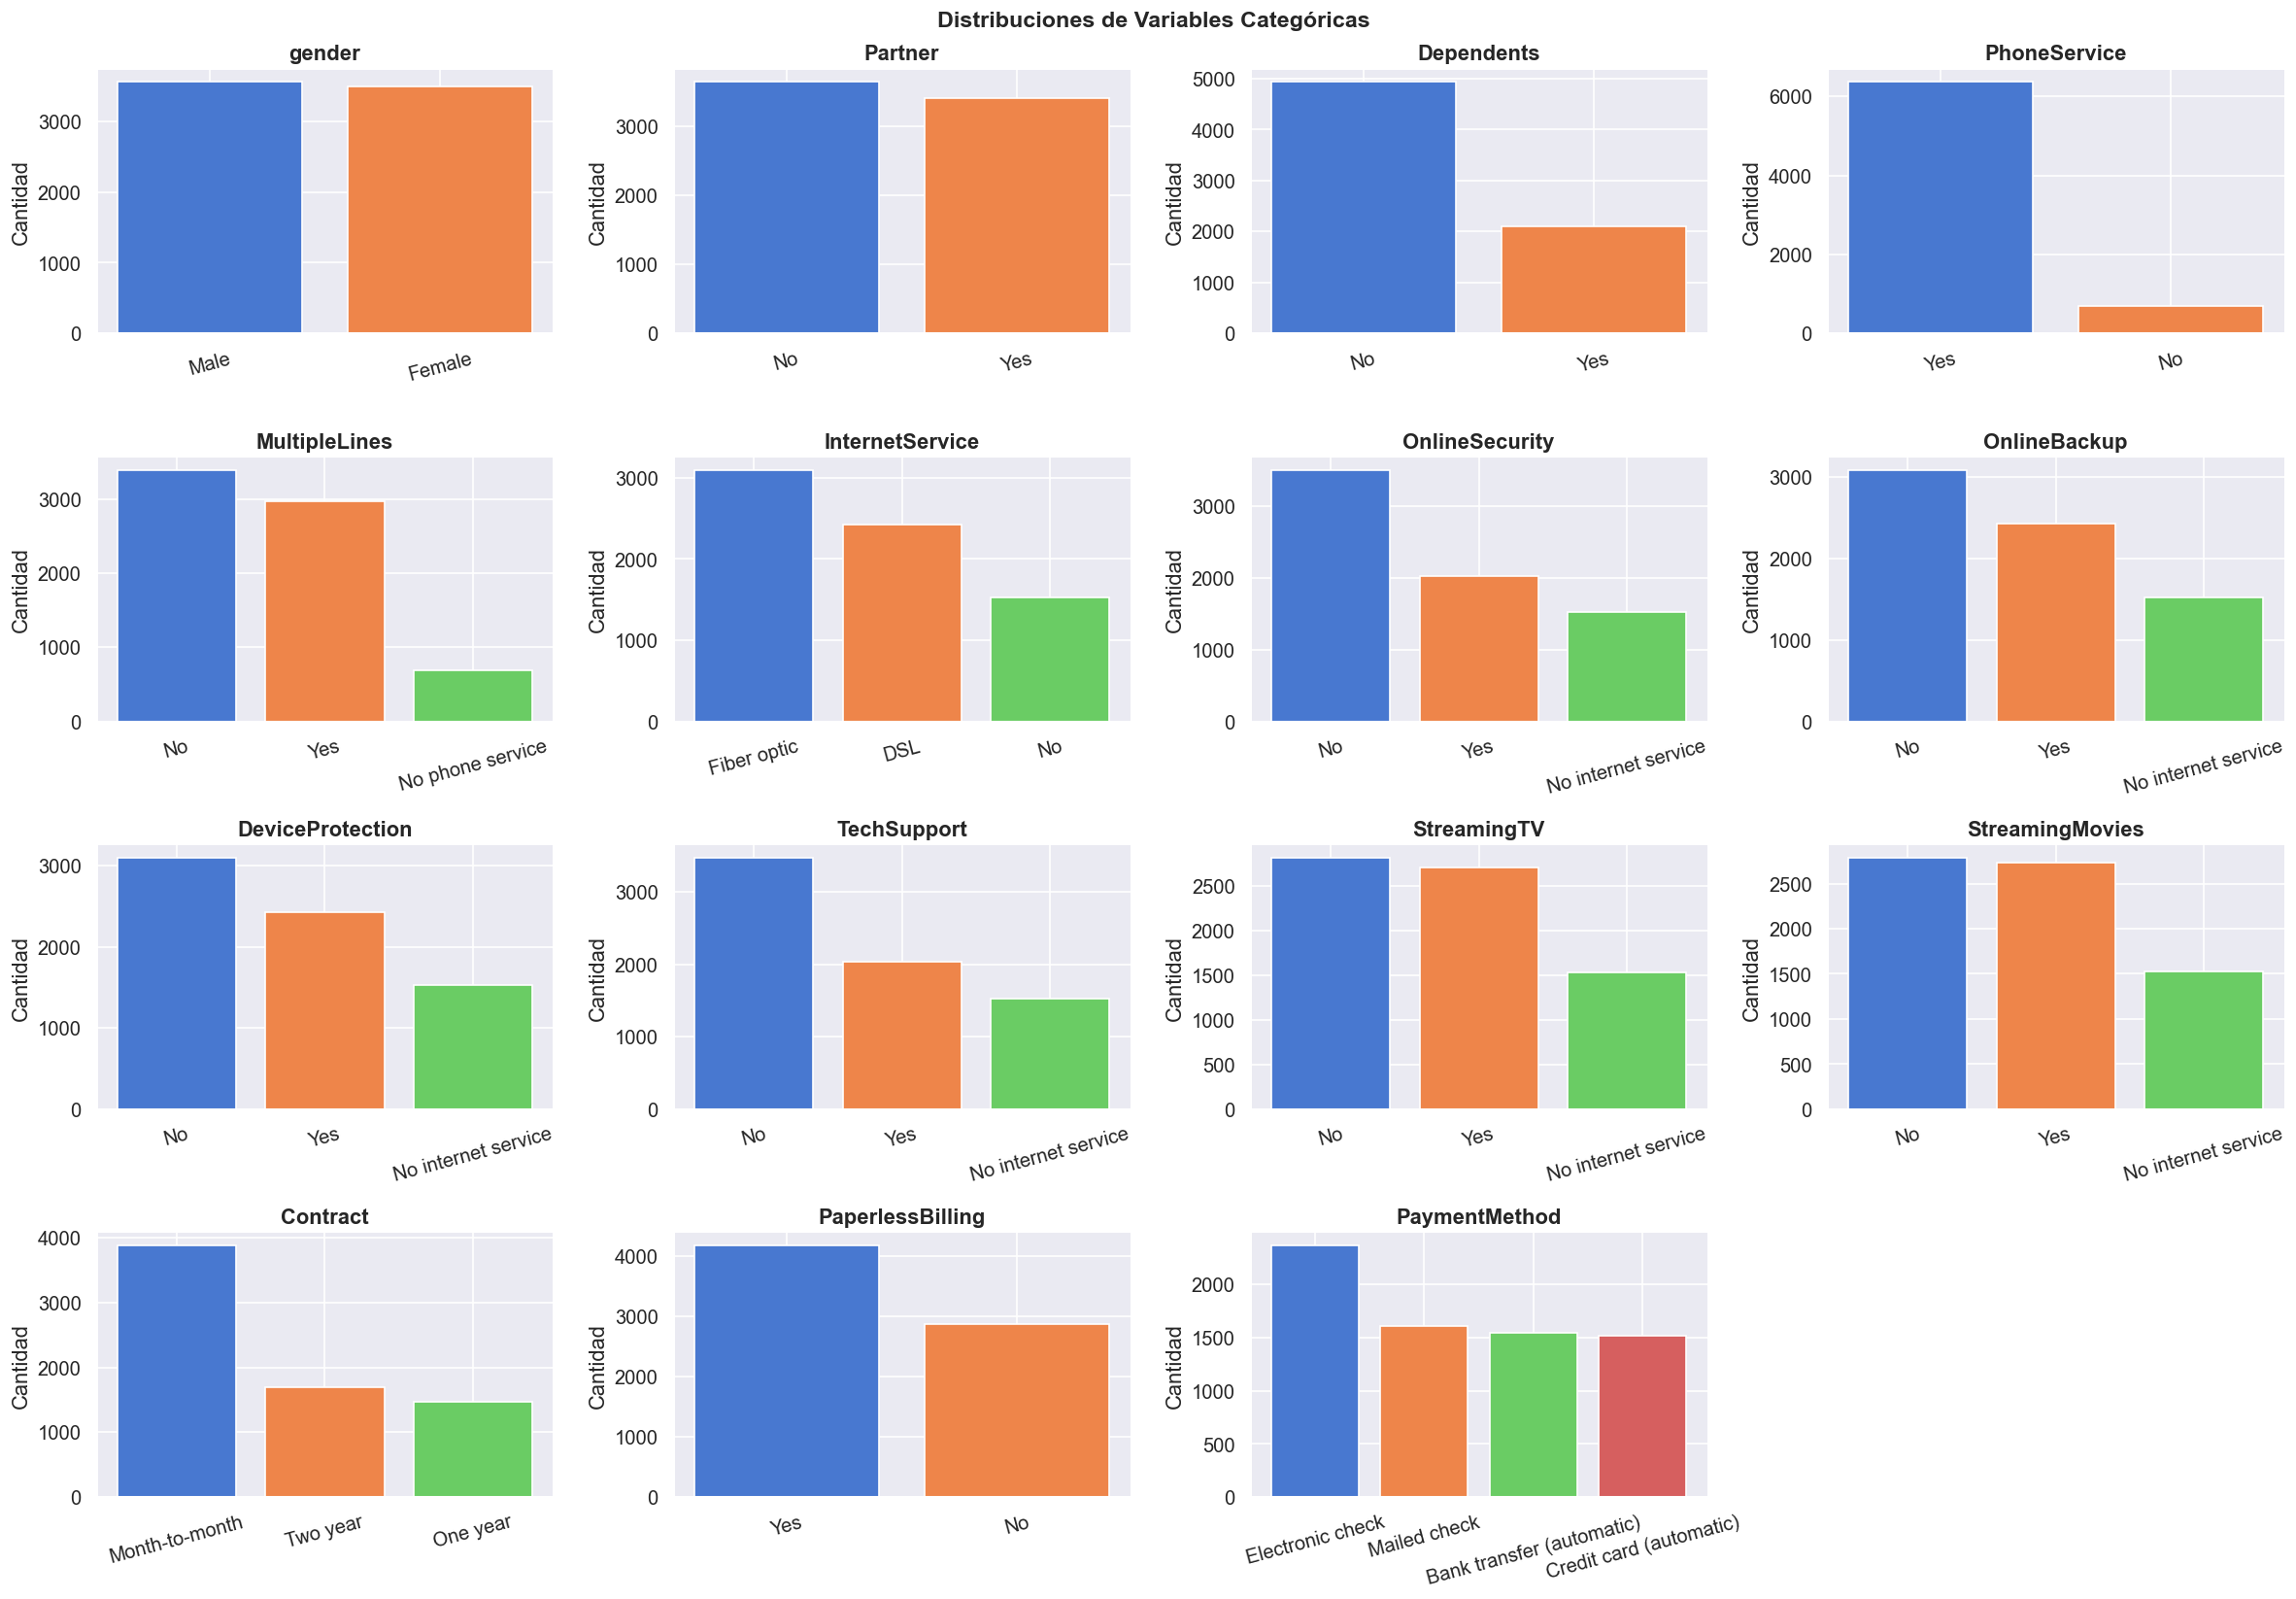

In [10]:
cols_cat = df.select_dtypes(include='object').columns.tolist()
cols_cat = [c for c in cols_cat if c not in ['customerID', 'Churn']]

n_cols = 4
n_filas = int(np.ceil(len(cols_cat) / n_cols))

fig, axes = plt.subplots(n_filas, n_cols, figsize=(20, n_filas * 3.5))
axes = axes.flatten()

for i, col in enumerate(cols_cat):
    conteos = df[col].value_counts()
    axes[i].bar(conteos.index, conteos.values, color=sns.color_palette('muted', len(conteos)), edgecolor='white')
    axes[i].set_title(col, fontweight='bold')
    axes[i].set_ylabel('Cantidad')
    axes[i].tick_params(axis='x', rotation=15)

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Distribuciones de Variables Categóricas', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---
## 4. Variable vs Churn

### 4.1 Variables Numéricas vs Churn — Box Plots

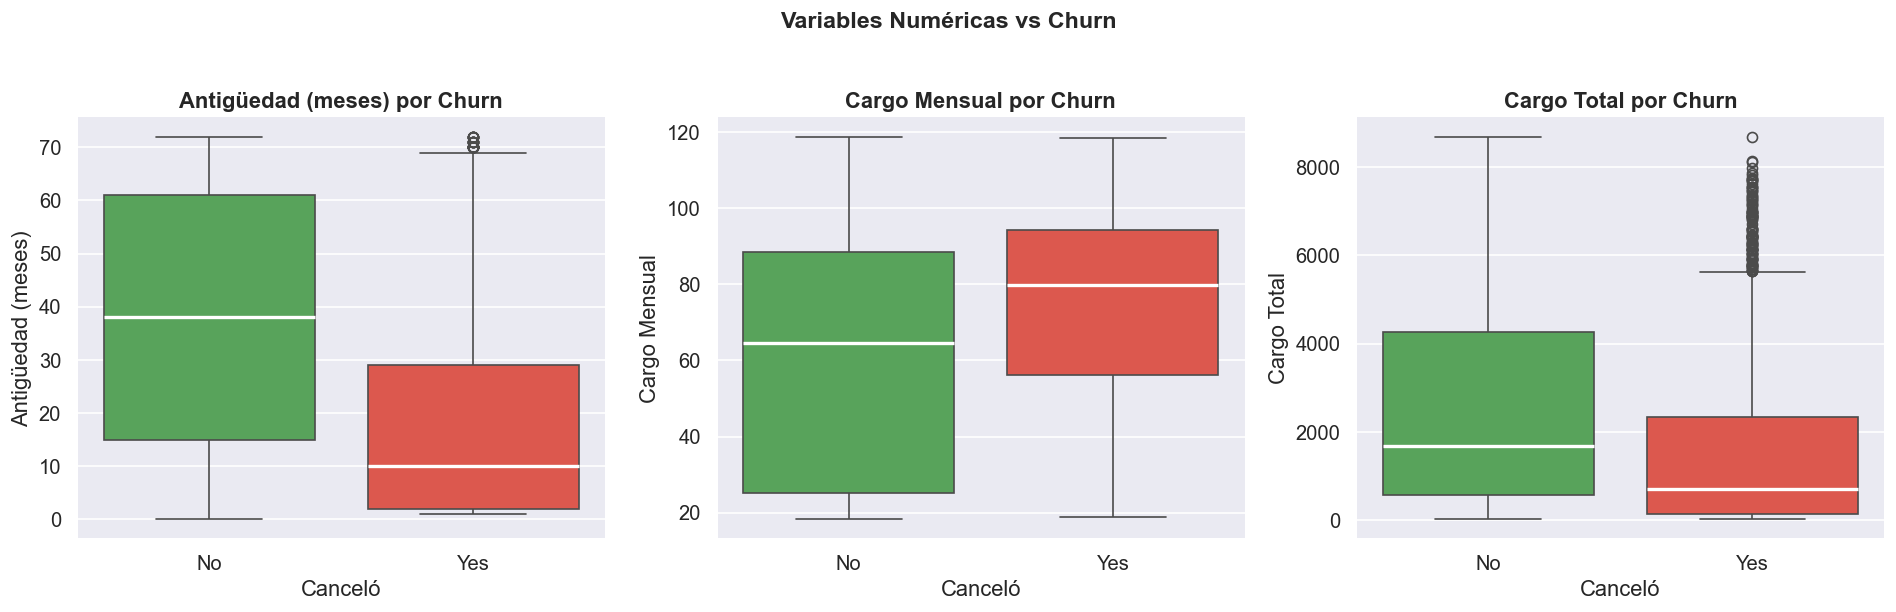

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
paleta = {'No': '#4CAF50', 'Yes': '#F44336'}
etiquetas = ['Antigüedad (meses)', 'Cargo Mensual', 'Cargo Total']

for ax, col, etiq in zip(axes, cols_num, etiquetas):
    sns.boxplot(data=df, x='Churn', y=col, palette=paleta, ax=ax, medianprops=dict(color='white', linewidth=2))
    ax.set_title(f'{etiq} por Churn', fontweight='bold')
    ax.set_xlabel('Canceló')
    ax.set_ylabel(etiq)

plt.suptitle('Variables Numéricas vs Churn', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 4.2 Variables Categóricas Clave — Tasa de Churn por Categoría

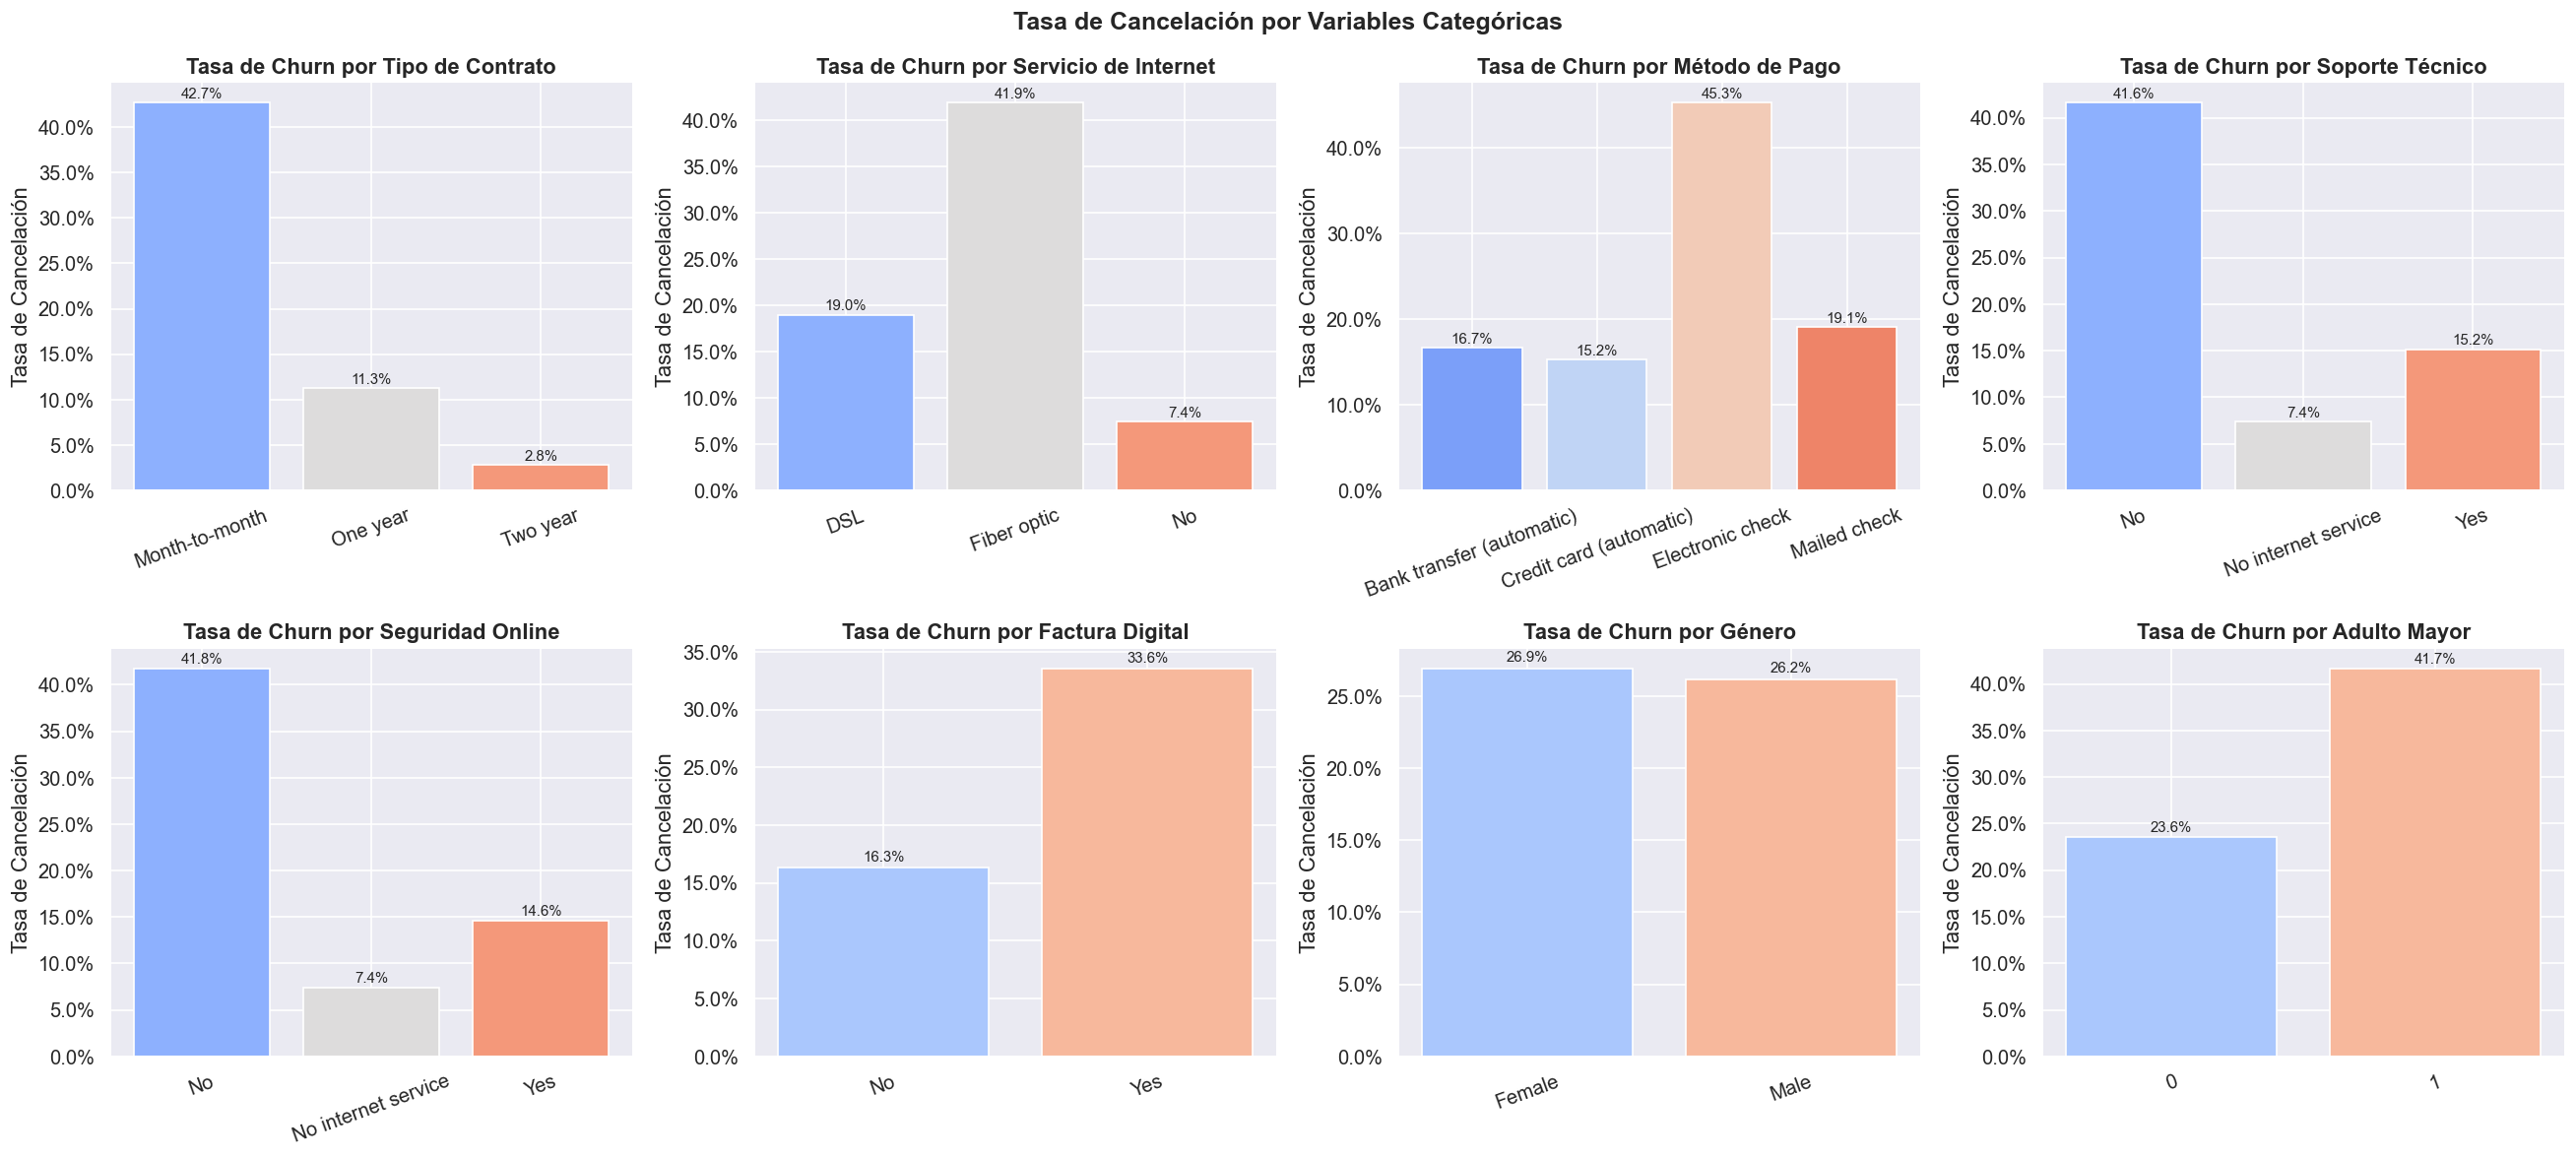

In [12]:
cats_clave = ['Contract', 'InternetService', 'PaymentMethod', 'TechSupport',
              'OnlineSecurity', 'PaperlessBilling', 'gender', 'SeniorCitizen']

etiquetas_cat = [
    'Tipo de Contrato', 'Servicio de Internet', 'Método de Pago', 'Soporte Técnico',
    'Seguridad Online', 'Factura Digital', 'Género', 'Adulto Mayor'
]

fig, axes = plt.subplots(2, 4, figsize=(22, 10))
axes = axes.flatten()

for i, (col, etiq) in enumerate(zip(cats_clave, etiquetas_cat)):
    tasa_churn = df.groupby(col)['Churn'].apply(lambda x: (x == 'Yes').mean() * 100)
    barras = axes[i].bar(tasa_churn.index.astype(str), tasa_churn.values, color=sns.color_palette('coolwarm', len(tasa_churn)), edgecolor='white')
    axes[i].yaxis.set_major_formatter(mtick.PercentFormatter())
    axes[i].set_title(f'Tasa de Churn por {etiq}', fontweight='bold')
    axes[i].set_ylabel('Tasa de Cancelación')
    axes[i].tick_params(axis='x', rotation=20)
    for barra, val in zip(barras, tasa_churn.values):
        axes[i].text(barra.get_x() + barra.get_width()/2, barra.get_height() + 0.5, f'{val:.1f}%', ha='center', fontsize=9)

plt.suptitle('Tasa de Cancelación por Variables Categóricas', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

### 4.3 Distribución de Antigüedad — Cancelados vs Retenidos

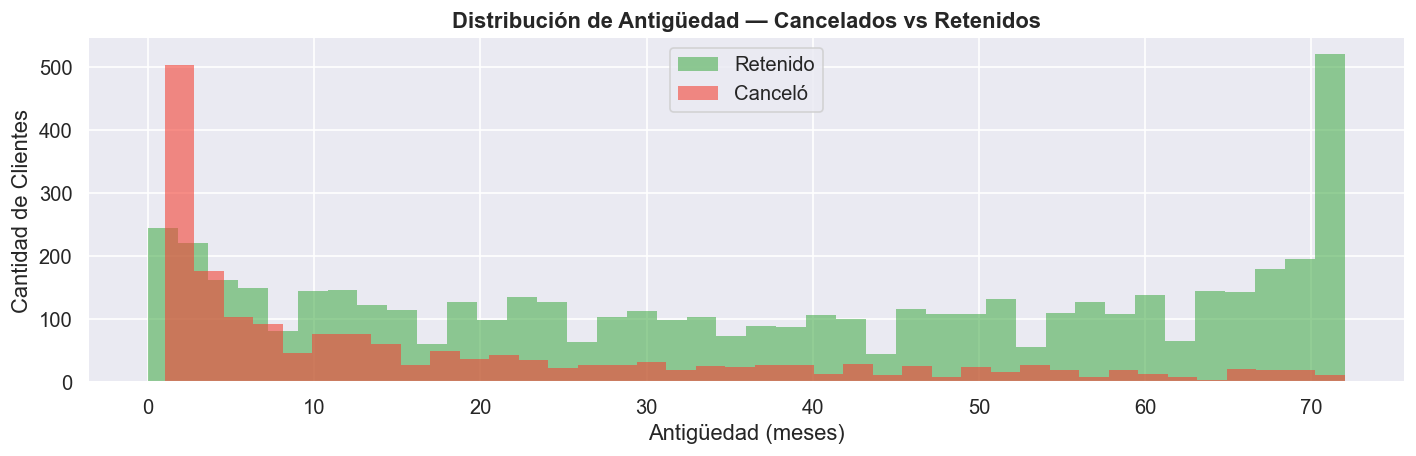

In [13]:
fig, ax = plt.subplots(figsize=(12, 4))

for val_churn, color, etiq in [('No', '#4CAF50', 'Retenido'), ('Yes', '#F44336', 'Canceló')]:
    subconjunto = df[df['Churn'] == val_churn]['tenure']
    ax.hist(subconjunto, bins=40, alpha=0.6, color=color, label=etiq, edgecolor='none')

ax.set_xlabel('Antigüedad (meses)')
ax.set_ylabel('Cantidad de Clientes')
ax.set_title('Distribución de Antigüedad — Cancelados vs Retenidos', fontweight='bold')
ax.legend()
plt.tight_layout()
plt.show()

---
## 5. Conclusiones Clave

| Hallazgo | Interpretación |
|---|---|
| **Tasa de churn ~26%** |
| **Clientes nuevos cancelan más** | Programas de fidelización y onboarding son cruciales |
| **Contratos mes a mes** | Mayor tasa de cancelación (~43%) vs contratos anuales (<12%) |
| **Sin Seguridad Online / Soporte Técnico** | Clientes sin estos servicios cancelan significativamente más |
| **Internet de fibra óptica** | Más cancelaciones que DSL — posiblemente por precio |
| **Cargos mensuales altos** | Quienes cancelan pagan más por mes en promedio |
| **Pago con cheque electrónico** | Mayor tasa de churn vs métodos de pago automático |


---
## 7. Preprocesamiento

In [14]:
datos = df.copy()

# 1. Eliminar ID del cliente (no es predictivo)
datos.drop(columns=['customerID'], inplace=True)

# 2. Corregir tipo de TotalCharges e imputar ~11 filas faltantes
datos['TotalCharges'] = pd.to_numeric(datos['TotalCharges'], errors='coerce')
datos['TotalCharges'].fillna(datos['TotalCharges'].median(), inplace=True)

# 3. Transformamos variable objetivo en 0 y 1
datos['Churn'] = datos['Churn'].map({'Yes': 1, 'No': 0})

# 4. Codificación binaria para categorías de 2 clases
cols_binarias = [c for c in datos.select_dtypes(include='object').columns
                 if datos[c].nunique() == 2]
le = LabelEncoder()
for col in cols_binarias:
    datos[col] = le.fit_transform(datos[col])
print(f'Columnas codificadas (binarias): {cols_binarias}')

# 5. Para columnas con múltiples categorías se crea columnas nuevas para cada opción
datos = pd.get_dummies(datos, drop_first=True)
print(f'Total de variables predictoras: {datos.shape[1] - 1}')

datos.head(3)

Columnas codificadas (binarias): ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
Total de variables predictoras: 30


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,1,29.85,29.85,0,...,False,False,False,False,False,False,False,False,True,False
1,1,0,0,0,34,1,0,56.95,1889.50,0,...,False,False,False,False,False,True,False,False,False,True
2,1,0,0,0,2,1,1,53.85,108.15,1,...,False,False,False,False,False,False,False,False,False,True


In [15]:
# División Train / Test 
X = datos.drop(columns=['Churn'])
y = datos['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEMILLA, stratify=y # stratify=y obliga a que tanto el grupo de entrenamiento como el de prueba tengan exactamente la misma proporción de cancelaciones (26.54%)
)

print(f'Entrenamiento: {X_train.shape[0]:,} muestras  |  Prueba: {X_test.shape[0]:,} muestras')
print(f'Tasa de churn — Train: {y_train.mean():.2%}  |  Test: {y_test.mean():.2%}')

Entrenamiento: 5,634 muestras  |  Prueba: 1,409 muestras
Tasa de churn — Train: 26.54%  |  Test: 26.54%


In [16]:
# Estandarización de variables numéricas 
escalador = StandardScaler()
cols_escala = ['tenure', 'MonthlyCharges', 'TotalCharges']

X_train = X_train.copy()
X_test  = X_test.copy()

X_train[cols_escala] = escalador.fit_transform(X_train[cols_escala])
X_test[cols_escala]  = escalador.transform(X_test[cols_escala])

print('Estandarización completada.')

Estandarización completada.


---
## 8. Modelo Base — Regresión Logística

In [17]:
lr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=SEMILLA)
lr.fit(X_train, y_train)

lr_preds = lr.predict(X_test)
lr_proba = lr.predict_proba(X_test)[:, 1]
lr_auc   = roc_auc_score(y_test, lr_proba)

print('=== Regresión Logística — Reporte de Clasificación ===')
print(classification_report(y_test, lr_preds, target_names=['No Canceló', 'Canceló']))
print(f'ROC-AUC: {lr_auc:.4f}')

=== Regresión Logística — Reporte de Clasificación ===
              precision    recall  f1-score   support

  No Canceló       0.90      0.72      0.80      1035
     Canceló       0.51      0.78      0.61       374

    accuracy                           0.74      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.80      0.74      0.75      1409

ROC-AUC: 0.8417


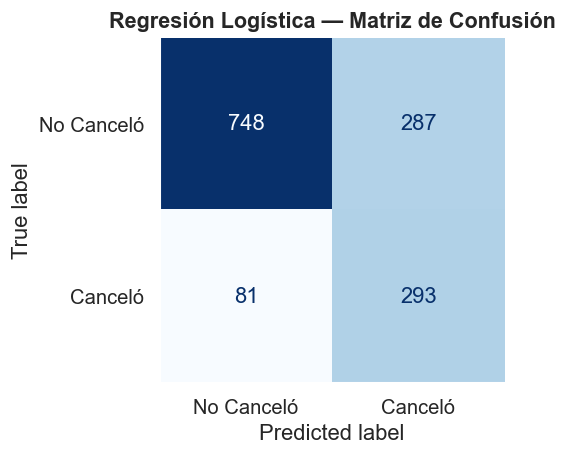

In [18]:
def graficar_matriz_confusion(y_true, y_pred, titulo, ax, cmap='Blues'):
    mc = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=mc, display_labels=['No Canceló', 'Canceló'])
    disp.plot(ax=ax, cmap=cmap, colorbar=False)
    ax.set_title(titulo, fontweight='bold', fontsize=13)
    ax.grid(False)

fig, ax = plt.subplots(figsize=(5, 4))
graficar_matriz_confusion(y_test, lr_preds, 'Regresión Logística — Matriz de Confusión', ax)
plt.tight_layout()
plt.show()

---
## 9. Modelo Avanzado — XGBoost (con Búsqueda de Hiperparámetros)

In [19]:
# Calculamos la proporción entre clientes que se quedan (neg) y los que se van (pos)
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
peso_pos = neg / pos # Este factor compensa el desbalance: le da más "peso" a los casos de churn
print(f'scale_pos_weight = {peso_pos:.2f}  (ratio neg/pos)')

grilla_params = {
    'n_estimators':     [100, 200, 300, 500],
    'max_depth':        [3, 4, 5, 6],
    'learning_rate':    [0.01, 0.05, 0.1, 0.2],
    'subsample':        [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5],
    'gamma':            [0, 0.1, 0.3],
}

# Inicialización del modelo base
xgb_base = XGBClassifier(
    scale_pos_weight=peso_pos, # Aplicamos el balance de clases calculado arriba
    eval_metric='auc',
    random_state=SEMILLA,
    verbosity=0,
    use_label_encoder=False
)

# Dividimos el train set en 5 partes para probar el modelo de forma robusta
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEMILLA)

# Búsqueda Aleatoria de Hiperparámetros 
# Prueba 25 combinaciones al azar para encontrar la mejor
busqueda = RandomizedSearchCV(
    xgb_base,
    param_distributions=grilla_params,
    n_iter=25,
    scoring='roc_auc',
    cv=cv,
    random_state=SEMILLA,
    n_jobs=-1,
    verbose=1
)

busqueda.fit(X_train, y_train)
print(f'\nMejor ROC-AUC (validación cruzada): {busqueda.best_score_:.4f}')
print(f'Mejores hiperparámetros: {busqueda.best_params_}')

scale_pos_weight = 2.77  (ratio neg/pos)
Fitting 5 folds for each of 25 candidates, totalling 125 fits



Mejor ROC-AUC (validación cruzada): 0.8491
Mejores hiperparámetros: {'subsample': 0.6, 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 0.8}


In [20]:
modelo_xgb = busqueda.best_estimator_

xgb_preds = modelo_xgb.predict(X_test)
xgb_proba = modelo_xgb.predict_proba(X_test)[:, 1]
xgb_auc   = roc_auc_score(y_test, xgb_proba)

print('=== XGBoost — Reporte de Clasificación ===')
print(classification_report(y_test, xgb_preds, target_names=['No Canceló', 'Canceló']))
print(f'ROC-AUC: {xgb_auc:.4f}')

=== XGBoost — Reporte de Clasificación ===
              precision    recall  f1-score   support

  No Canceló       0.91      0.73      0.81      1035
     Canceló       0.52      0.81      0.63       374

    accuracy                           0.75      1409
   macro avg       0.72      0.77      0.72      1409
weighted avg       0.81      0.75      0.76      1409

ROC-AUC: 0.8468


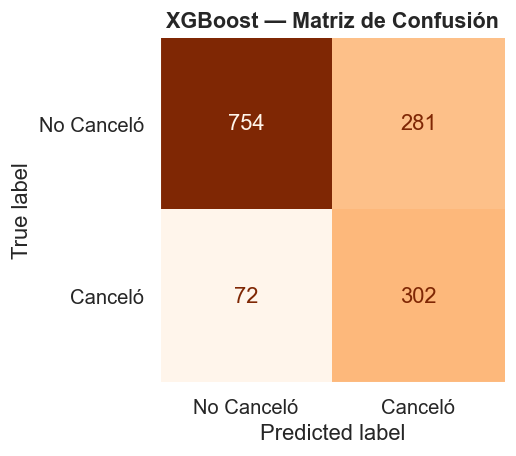

In [21]:
fig, ax = plt.subplots(figsize=(5, 4))
graficar_matriz_confusion(y_test, xgb_preds, 'XGBoost — Matriz de Confusión', ax, cmap='Oranges')
plt.tight_layout()
plt.show()

### 9.1 Importancia de Variables

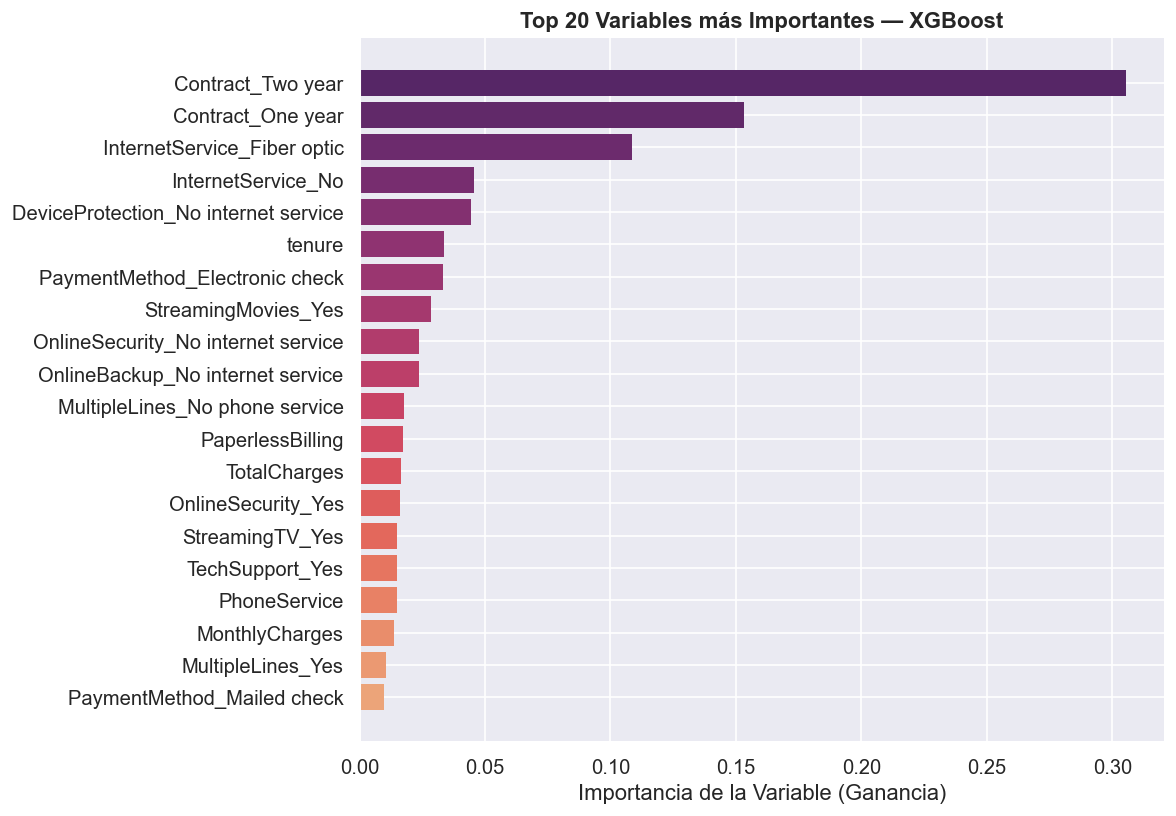

In [22]:
importancias = pd.Series(modelo_xgb.feature_importances_, index=X_train.columns)
top20 = importancias.nlargest(20).sort_values()

fig, ax = plt.subplots(figsize=(10, 7))
ax.barh(top20.index, top20.values, color=sns.color_palette('flare', 20), edgecolor='none')
ax.set_xlabel('Importancia de la Variable (Ganancia)')
ax.set_title('Top 20 Variables más Importantes — XGBoost', fontweight='bold')
plt.tight_layout()
plt.show()

---
## 10. Comparación de Modelos

In [23]:
def obtener_metricas(y_true, y_pred, y_proba):
    return {
        'Exactitud (Accuracy)':  accuracy_score(y_true, y_pred),
        'Precisión (Precision)': precision_score(y_true, y_pred),
        'Sensibilidad (Recall)': recall_score(y_true, y_pred),
        'F1-Score':              f1_score(y_true, y_pred),
        'ROC-AUC':               roc_auc_score(y_true, y_proba),
    }

metricas_df = pd.DataFrame({
    'Regresión Logística': obtener_metricas(y_test, lr_preds,  lr_proba),
    'XGBoost':             obtener_metricas(y_test, xgb_preds, xgb_proba),
}).T

display(metricas_df.style
        .format('{:.4f}')
        .set_caption('Comparación de Modelos — Conjunto de Prueba')
        .set_table_styles([{'selector': 'caption',
                            'props': [('font-size', '14px'), ('font-weight', 'bold')]}])
        .highlight_max(axis=0, color='#d4edda')
        .highlight_min(axis=0, color='#f8d7da'))

,Exactitud (Accuracy),Precisión (Precision),Sensibilidad (Recall),F1-Score,ROC-AUC
Regresión Logística,0.7388,0.5052,0.7834,0.6143,0.8417
XGBoost,0.7495,0.5180,0.8075,0.6311,0.8468


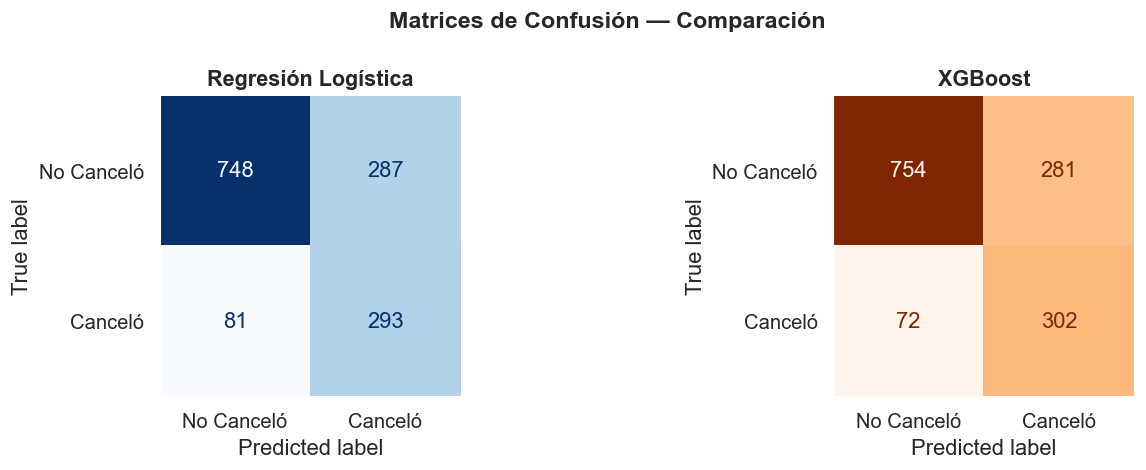

In [24]:
# Matrices de Confusión lado a lado
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
graficar_matriz_confusion(y_test, lr_preds,  'Regresión Logística', axes[0], cmap='Blues')
graficar_matriz_confusion(y_test, xgb_preds, 'XGBoost',             axes[1], cmap='Oranges')
plt.suptitle('Matrices de Confusión — Comparación', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---
### 📈 Análisis del Trade-off: Precisión vs Sensibilidad (Recall)
Es común notar una **Precisión** más baja (~0.52) comparada con la **Sensibilidad** (~0.81). Esto no es un error, sino una **decisión técnica y de negocio**:

1. **Costo de Oportunidad**: Es mucho más costoso perder a un cliente (Falso Negativo) que ofrecer un pequeño incentivo a alguien que no pensaba irse (Falso Positivo).
2. **El Balance**: Al optimizar para capturar el 81% de los abandonos, "abrimos la red" más, lo que genera más falsas alarmas.
3. **Curva P-R**: Abajo vemos cómo al intentar subir el Recall, la precisión cae. El **Average Precision (AP)** nos da una mejor idea del rendimiento general que la precisión en un punto fijo.

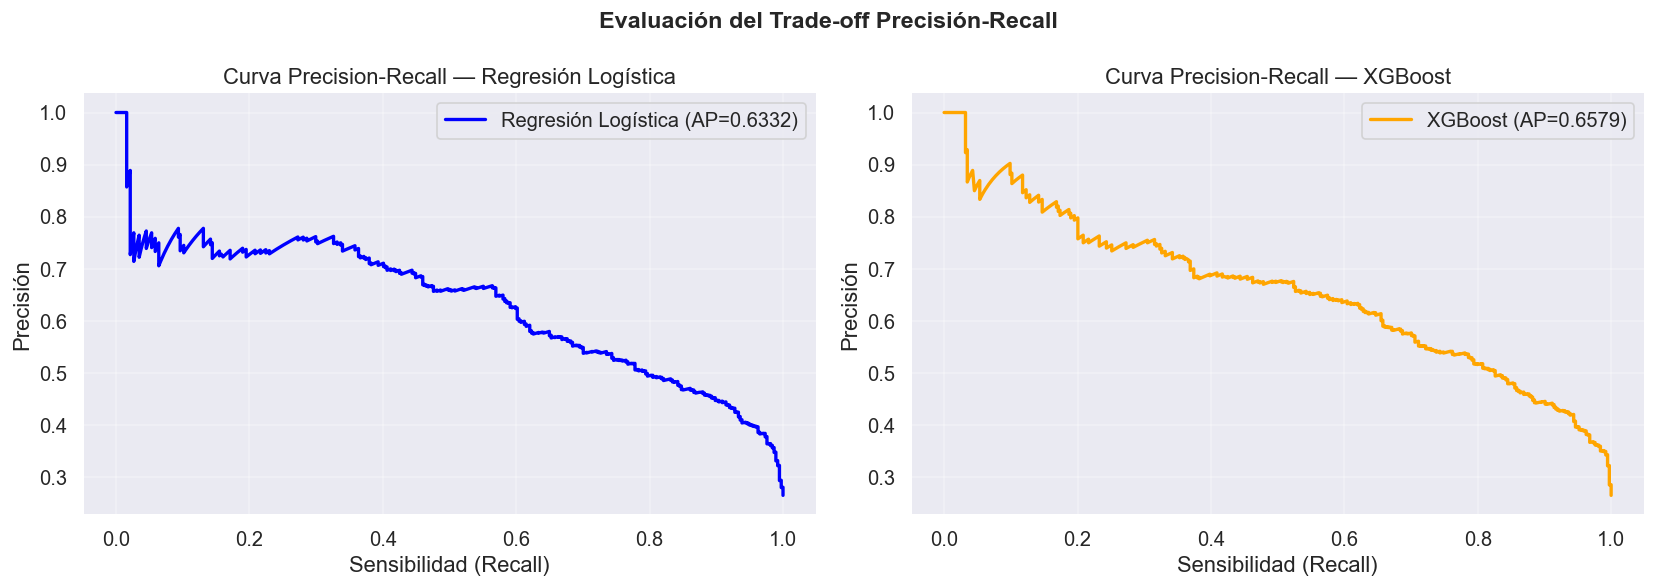

Average Precision - Regresión Logística: 0.6332
Average Precision - XGBoost:             0.6579


In [25]:
from sklearn.metrics import precision_recall_curve, average_precision_score

def graficar_curva_pr(y_true, y_proba, nombre_modelo, ax, color):
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    avg_precision = average_precision_score(y_true, y_proba)
    
    ax.plot(recall, precision, color=color, lw=2, label=f'{nombre_modelo} (AP={avg_precision:.4f})')
    ax.set_xlabel('Sensibilidad (Recall)')
    ax.set_ylabel('Precisión')
    ax.set_title(f'Curva Precision-Recall — {nombre_modelo}')
    ax.legend(loc='best')
    ax.grid(alpha=0.3)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Graficamos para ambos modelos
graficar_curva_pr(y_test, lr_proba,  'Regresión Logística', axes[0], 'blue')
graficar_curva_pr(y_test, xgb_proba, 'XGBoost',             axes[1], 'orange')

plt.suptitle('Evaluación del Trade-off Precisión-Recall', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Resumen de Average Precision
print(f'Average Precision - Regresión Logística: {average_precision_score(y_test, lr_proba):.4f}')
print(f'Average Precision - XGBoost:             {average_precision_score(y_test, xgb_proba):.4f}')

---
## Recomendaciones de Negocio
- 🎯 Apuntar a clientes con **contrato mes a mes** con ofertas de retención
- 📞 Ofrecer proactivamente **Soporte Técnico / Seguridad Online** a segmentos de alto riesgo
- 💳 Incentivar el uso de **métodos de pago automáticos** (menor tasa de churn)
- ⏳ Priorizar los **primeros 12 meses** de relación — mayor ventana de riesgo de cancelación